<a href="https://colab.research.google.com/github/guimiaozhang/forcasting-grad-admission/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import seaborn as sns

from google.colab import drive
drive.mount('gdrive')
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/project/Admission_Predict.csv', header=0)

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


#**Explanatory Research**
####1 data shape, parameters, missing values
####2 remove irrelavant / no real meaning parameters
####3 basic stat summary and correlation
####4 decide threshold to set up admission status
####5 prepare for train and test data, normalize X

In [ ]:
print('Data Shape: ', df.shape)
print('Data Columns: ', list(df.columns))
print('Data contains any NAs:', df.isnull().values.any())
print('Data head: ', df.head())

Data Shape:  (500, 9)
Data Columns:  ['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit ']
Data contains any NAs: False
Data head:     Serial No.  GRE Score  TOEFL Score  ...  CGPA  Research  Chance of Admit 
0           1        337          118  ...  9.65         1              0.92
1           2        324          107  ...  8.87         1              0.76
2           3        316          104  ...  8.00         1              0.72
3           4        322          110  ...  8.67         1              0.80
4           5        314          103  ...  8.21         0              0.65

[5 rows x 9 columns]


The Serial No. feature does not have any significance as it is an increasing value served as ID number.


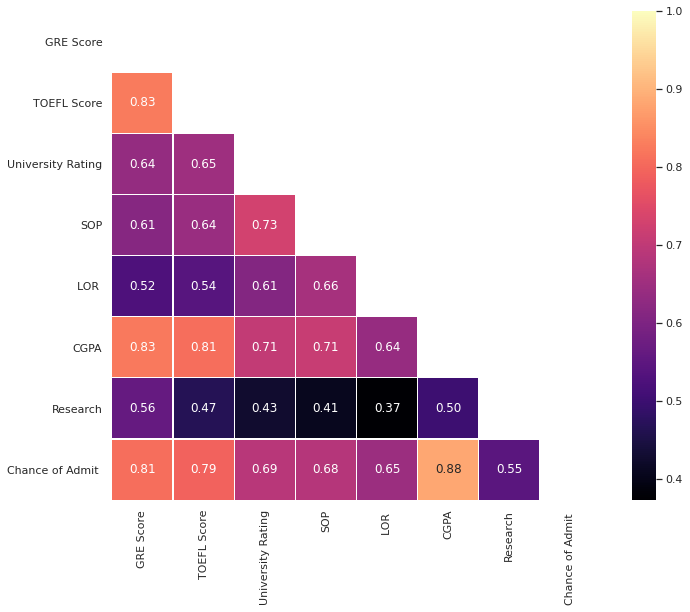

Basic Stat Summary:



,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [ ]:
print('The Serial No. feature does not have any significance as it is an increasing value served as ID number.')
#now drop the Serial No. columm as we still can distinguish each person by the row number.
data=df.drop(['Serial No.'],axis=1) #1 column 0 row

corr=data.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask,linewidths=0.05, fmt= '.2f',cmap="magma",square=True,)
plt.show()
print('Basic Stat Summary:\n')
data.describe()


In [ ]:
#as above, chance of admite are highly correlated w/ GRE, TOEFL & CGPA, we use 75% above of each to 
#set the threshold to determine if admitted or not
toppers=df[(data['GRE Score']>=325) & (data['TOEFL Score']>=112) & (data['CGPA']>=9.04)].sort_values(by=['Chance of Admit '],ascending=False)
toppers

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
202,203,340,120,5,4.5,4.5,9.91,1,0.97
24,25,336,119,5,4.0,3.5,9.80,1,0.97
143,144,340,120,4,4.5,4.0,9.92,1,0.97
203,204,334,120,5,4.0,5.0,9.87,1,0.97
213,214,333,119,5,5.0,4.5,9.78,1,0.96
...,...,...,...,...,...,...,...,...,...
487,488,327,115,4,3.5,4.0,9.14,0,0.79
69,70,328,115,4,4.5,4.0,9.16,1,0.78
12,13,328,112,4,4.0,4.5,9.10,1,0.78
243,244,325,114,3,3.5,3.0,9.04,1,0.76


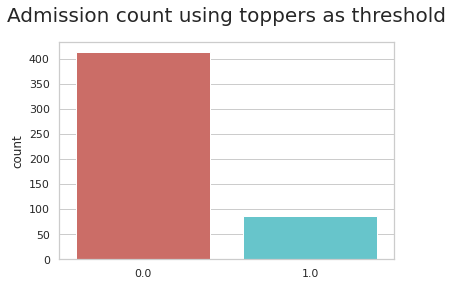

In [ ]:
#87 out of 500 are in top list, use this list as admission list
#as most student would be optimistic, it is often that they predict a higher chance 
#of admit then the reallity, we would not use 0.50 of chance of admit as threshold
y2=np.zeros(500)
for i in range(500):
  if (data['GRE Score'][i]>=325) & (data['TOEFL Score'][i]>=112) & (data['CGPA'][i]>=9.04): y2[i]=1 

sns.countplot(y2, palette='hls')
plt.title("Admission count using toppers as threshold", fontdict={'fontsize':20}, pad=20)
plt.show()

X=data.drop('Chance of Admit ',axis=1)

from sklearn import preprocessing

#Normalisation works slightly better for Regression.
X=preprocessing.normalize(X)

y1=data['Chance of Admit ']

np.random.seed(seed=123)
X_train,X_test,y1_train,y1_test,y2_train,y2_test=train_test_split(X,y1,y2,test_size=0.33)

# **Linear Regression**

model built with assumptions check, prediction $R^2$, adjusted $R^2$, MSE\
model selection using $R^2$, adjusted $R^2$

Using all features, linear regression will give us:

    The mean squared error is 0.005954605609283159
    The r-squared is  0.7111220642284228
    The adjusted r-squared is  0.698242156264085


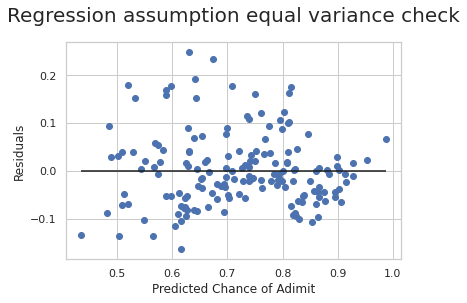

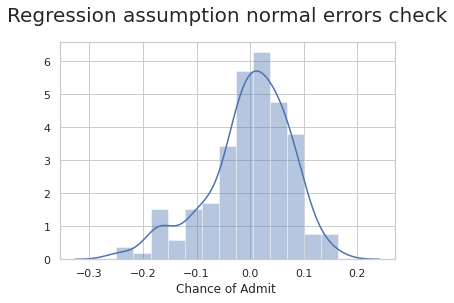

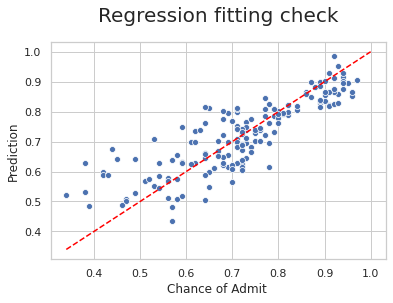

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

def adj_r2(n,p,r2):
  '''different from r2, penalize for too many predictors'''
  ratio=float(n-1)/float(n-p-1)
  return 1-(1-r2)*ratio

def get_adj_r2(X_test,y_test):
  y_pred=clf.predict(X_test)
  r2=r2_score(y_test,y_pred)
  n=len(y_test)
  p=X.shape[1]
  return adj_r2(n,p,r2)

def plot_lr_yr(y_test,y_pred):
  #residual vs fitted
  plt.scatter(y_pred, y_pred - y_test)
  plt.title('Regression assumption equal variance check',fontdict={'fontsize':20}, pad=20)
  plt.ylabel('Residuals')
  plt.xlabel('Predicted Chance of Adimit')
  plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max())
  plt.show()
  #residual distribution
  sns.distplot((y_test - y_pred))
  plt.title('Regression assumption normal errors check', fontdict={'fontsize':20}, pad=20)
  plt.show()
  #fitted vs observed
  plt.title('Regression fitting check', fontdict={'fontsize':20}, pad=20)
  plt.ylabel('Prediction')
  sns.scatterplot(x=y_test,y=y_pred)
  plt.plot([0.34, 1], [0.34, 1],linestyle='--',color='red')
  plt.show()

def linear_stat(clf,X_train,y_train,X_test,y_test):
  clf.fit(X_train,y_train)
  b0=clf.intercept_
  b=clf.coef_
  y_pred=clf.predict(X_test)
  mse=mean_squared_error(y_test, y_pred)
  r2=r2_score(y_test,y_pred)
  adj=get_adj_r2(X_test,y_test)
  print("Using all features, linear regression will give us:\n")
  #print('Fitted model: Chance of admit = ',b0,'+ ',b[0],'GRE Score +',b[1],'TOEFL Score +\n',
   #     b[2],'University Rating +',b[3],'SOP +', b[4],'LOR +\n',b[5],'CGPA +',b[6],	'Research\n.')
  print('    The mean squared error is' , mse)
  print('    The r-squared is ', r2)
  print('    The adjusted r-squared is ', adj)
  plot_lr_yr(y_test,y_pred)
  return mse,r2,adj

clf=LinearRegression()
mse,r2,adj=linear_stat(clf,X_train,y1_train,X_test,y1_test)

(335, 3)
Using all features, linear regression will give us:

    The mean squared error is 0.008789699326593457
    The r-squared is  0.5735821372349774
    The adjusted r-squared is  0.5545698758378108


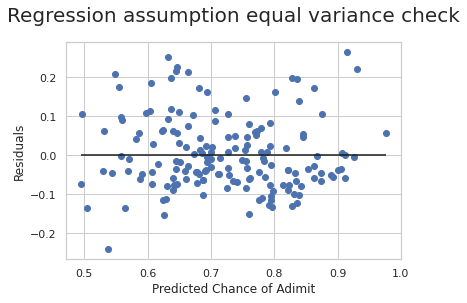

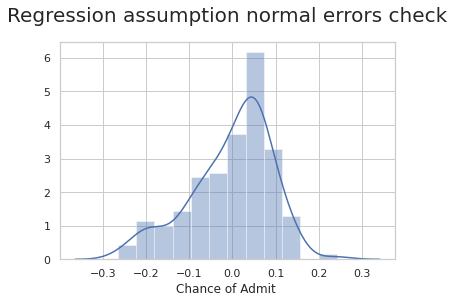

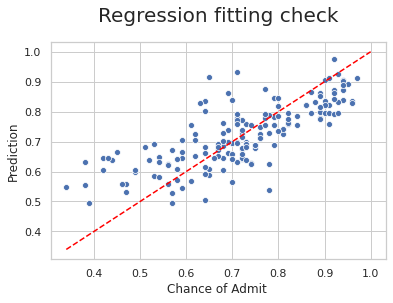

(0.008789699326593457, 0.5735821372349774, 0.5545698758378108)

In [ ]:
'''
some model selections were also done, but with lower adj R^2,
thus, keep all features in prediction model
'''
#X_train1,X_test1=X_train[:,(0,1,2,4,5)],X_test[:,(0,1,2,4,5)]
X_train1,X_test1=X_train[:,(0,1,5)],X_test[:,(0,1,5)]

print(X_train1.shape)

clf=LinearRegression()
linear_stat(clf,X_train1,y1_train,X_test1,y1_test)

#**Logistic Regression**
Grid search for best

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_roc_curve

parameters=[{'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'class_weight':('balanced',None),},]
log=GridSearchCV(LogisticRegression(),parameters,scoring='accuracy')
log.fit(X_train,y2_train)
print('Best parameters set:')
print(log.best_params_)

Best parameters set:
{'C': 0.1, 'class_weight': None}


Logistic Regression Accuracy 0.8181818181818182


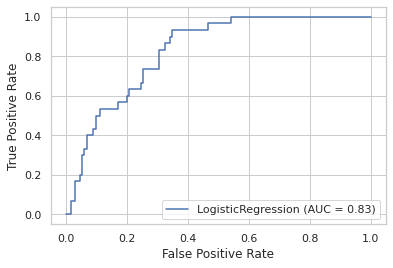

In [ ]:
log_best=LogisticRegression(C= 0.1, class_weight=None)
log_best.fit(X_train,y2_train)
y2_pred = log_best.predict(X_test)
log_acc=accuracy_score(y2_test,y2_pred)
print('Logistic Regression Accuracy',log_acc)
plot_roc_curve(log_best,X_test,y2_test)
plt.show()

#**KNN**
##1 KNN regressor
##2 KNN classifier
Grid search for parameters, comparisions

In [ ]:
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
parameters=[{'n_neighbors':np.arange(2,33),'weights':('uniform','distance')},]

knn_c=GridSearchCV(KNeighborsClassifier(),parameters,scoring='accuracy')
knn_c.fit(X_train,y2_train)
print('Best parameters set for KNN Classifier:')
print(knn_c.best_params_)

knn_r=GridSearchCV(KNeighborsRegressor(),parameters,scoring='explained_variance')
knn_r.fit(X_train,y1_train)
print('Best parameters set for KNN regressor:')
print(knn_r.best_params_)

Best parameters set for KNN Classifier:
{'n_neighbors': 19, 'weights': 'uniform'}
Best parameters set for KNN regressor:
{'n_neighbors': 4, 'weights': 'distance'}


Using  {'n_neighbors': 4, 'weights': 'distance'} KNN regressor will give us:

    The mean squared error is 0.007567319165169513
    The adjusted r-squared is  0.6165156747605465


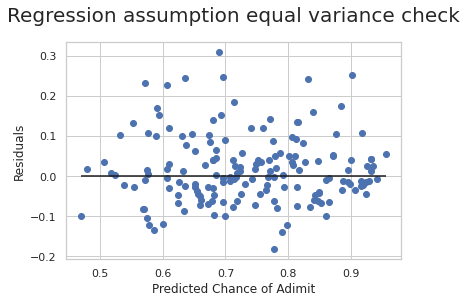

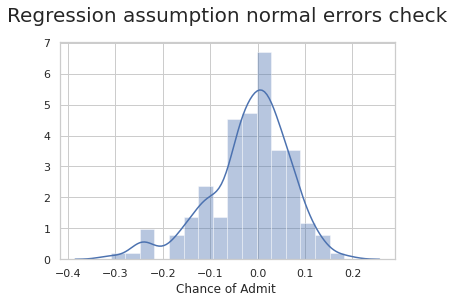

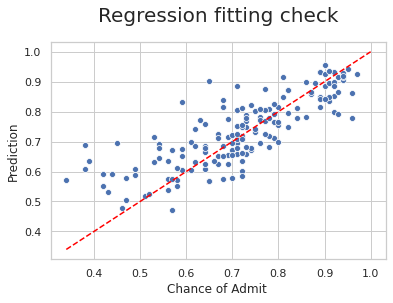

Linear V.S. KNN regressor



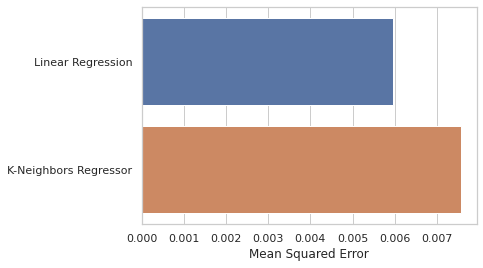

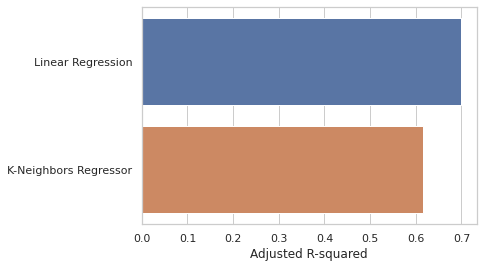

In [ ]:
knn_r_1=KNeighborsRegressor(n_neighbors=4, weights='distance')
knn_r_1.fit(X_train,y1_train)
y1_pred = knn_r_1.predict(X_test)
clf=knn_r_1
adj_r2_knn=get_adj_r2(X_test,y1_test)
mse_knn=mean_squared_error(y1_test,y1_pred)

print("Using ",knn_r.best_params_, "KNN regressor will give us:\n")
print('    The mean squared error is' , mse_knn)
print('    The adjusted r-squared is ', adj_r2_knn)
plot_lr_yr(y1_test,y1_pred)

print('Linear V.S. KNN regressor\n')
y_ax=['Linear Regression' , 'K-Neighbors Regressor']
x_ax1=[mse,mse_knn]
sns.barplot(x=x_ax1,y=y_ax)
plt.xlabel('Mean Squared Error')
plt.show()
x_ax2=[adj,adj_r2_knn]
sns.barplot(x=x_ax2,y=y_ax)
plt.xlabel('Adjusted R-squared')
plt.show()


KNN classifier Accuracy 0.8606060606060606


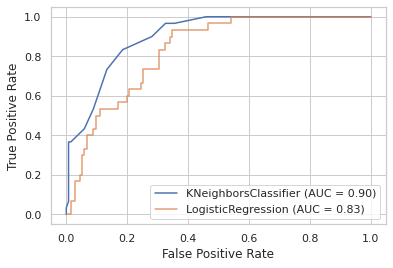

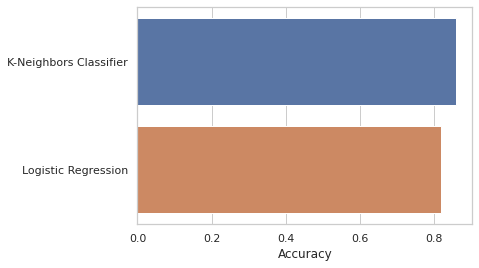

In [ ]:
knn_c_1=KNeighborsClassifier(n_neighbors=19, weights='uniform')
knn_c_1.fit(X_train,y2_train)
y2_pred = knn_c_1.predict(X_test)
knn_c_acc=accuracy_score(y2_test,y2_pred)
print('KNN classifier Accuracy',knn_c_acc)

plot_roc_curve(knn_c_1,X_test,y2_test)
ax = plt.gca()
plot_roc_curve(log_best, X_test, y2_test, ax=ax, alpha=0.8)
plt.show()


y_ax=[ 'K-Neighbors Classifier','Logistic Regression' ]
x_ax=[knn_c_acc,log_acc]
sns.barplot(x=x_ax,y=y_ax)
plt.xlabel('Accuracy')
plt.show()
